In [1]:
#https://github.com/vermaMachineLearning/keras-deep-graph-learning

In [1]:
import warnings
warnings.filterwarnings(action='ignore')
import pandas as pd
import numpy as np
import matplotlib

import rdkit
import rdkit.Chem
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem.SaltRemover import SaltRemover

from tqdm import tnrange, tqdm_notebook

import time

#from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import balanced_accuracy_score,cohen_kappa_score
from sklearn.metrics import hamming_loss,jaccard_score.

In [2]:
rdkit.__version__

'2020.03.6'

In [3]:
! conda info --envs

# conda environments:
#
base                     C:\ProgramData\Anaconda3
docker_api               C:\ProgramData\Anaconda3\envs\docker_api
paper                 *  C:\ProgramData\Anaconda3\envs\paper
py27                     C:\ProgramData\Anaconda3\envs\py27
py_37                    C:\ProgramData\Anaconda3\envs\py_37
rstudio                  C:\ProgramData\Anaconda3\envs\rstudio



In [4]:
#acc, f1-score, g-mean, auc, auprc
def gmean_score(y_true,y_pred):
    tn,fp,fn,tp = confusion_matrix(y_true,y_pred).ravel()
    return ((tp/(tp+fn))*(tn/(tn+fp)))**(1/2)

In [5]:
def MCC_score(y_true,y_pred):
    tn,fp,fn,tp = confusion_matrix(y_true,y_pred).ravel()
    return ((tp*tn)-(fp*fn))/(((tp+fp)*(fn+tn)*(fp+tn)*(tp+fn))**(1/2))

# DrugBank Data

In [6]:
drugbank = pd.read_csv("../Data/drugbank_all_structure_links.csv")

In [7]:
drugbank['DrugBank ID'].value_counts()

DB04864    1
DB13167    1
DB05464    1
DB00289    1
DB00843    1
          ..
DB14755    1
DB09074    1
DB04388    1
DB01263    1
DB00455    1
Name: DrugBank ID, Length: 11414, dtype: int64

# Data Matrix

In [8]:
data = pd.read_csv("../Data/sider_data.csv")

In [9]:
data

,drugbank_id,drugbank_name,pubchem_id,umls_cui_from_meddra,side_effect_name
0,DB07768,"(10ALPHA,13ALPHA,14BETA,17ALPHA)-17-HYDROXYAND...",6013,C0000729,Abdominal cramps
1,DB07768,"(10ALPHA,13ALPHA,14BETA,17ALPHA)-17-HYDROXYAND...",6013,C0000737,Abdominal pain
2,DB07768,"(10ALPHA,13ALPHA,14BETA,17ALPHA)-17-HYDROXYAND...",6013,C0232492,Abdominal pain upper
3,DB07768,"(10ALPHA,13ALPHA,14BETA,17ALPHA)-17-HYDROXYAND...",6013,C0740651,Abdominal symptom
4,DB07768,"(10ALPHA,13ALPHA,14BETA,17ALPHA)-17-HYDROXYAND...",6013,C0877331,Abnormal clotting factor
...,...,...,...,...,...
153658,DB05738,vapitadine dihydrochloride,312,C0015230,Rash
153659,DB05738,vapitadine dihydrochloride,312,C0234233,Tenderness
153660,DB05738,vapitadine dihydrochloride,312,C0041582,Ulcer
153661,DB05738,vapitadine dihydrochloride,312,C0042487,Venous thrombosis


In [10]:
data[['drugbank_id','side_effect_name']]

,drugbank_id,side_effect_name
0,DB07768,Abdominal cramps
1,DB07768,Abdominal pain
2,DB07768,Abdominal pain upper
3,DB07768,Abdominal symptom
4,DB07768,Abnormal clotting factor
...,...,...
153658,DB05738,Rash
153659,DB05738,Tenderness
153660,DB05738,Ulcer
153661,DB05738,Venous thrombosis


In [11]:
data['drugbank_id'].value_counts()

DB00230    839
DB01238    827
DB01175    823
DB00215    823
DB00268    682
          ... 
DB06691      1
DB01303      1
DB08604      1
DB00122      1
DB04789      1
Name: drugbank_id, Length: 1223, dtype: int64

In [12]:
#각 약들이 몇개의 side effect를 가지고있는지
data['drugbank_id'].value_counts().describe()

count    1223.000000
mean      125.644317
std       122.839377
min         1.000000
25%        42.000000
50%        90.000000
75%       169.500000
max       839.000000
Name: drugbank_id, dtype: float64

<AxesSubplot:>

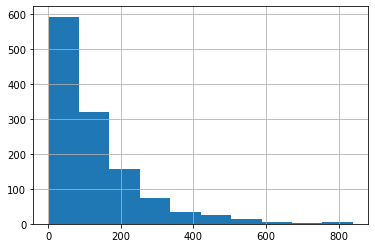

In [13]:
data['drugbank_id'].value_counts().hist()

In [14]:
#각 side effect를 가지고있는 약물이 몇개인지
data['side_effect_name'].value_counts().describe()

count    5734.000000
mean       26.798570
std        80.392505
min         1.000000
25%         1.000000
50%         4.000000
75%        13.000000
max      1038.000000
Name: side_effect_name, dtype: float64

<AxesSubplot:>

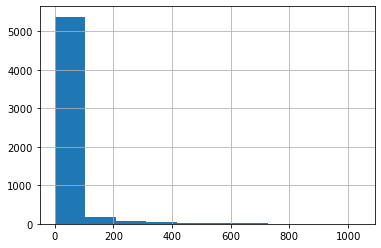

In [15]:
data['side_effect_name'].value_counts().hist()

In [16]:
cross_tab = pd.crosstab(data.drugbank_id,data.side_effect_name,margins=True)

In [17]:
cross_tab = cross_tab[cross_tab.columns[cross_tab.loc['All']>=100]]
cross_tab = cross_tab[cross_tab.All>=50]
#cross_tab

In [18]:
drug_side_matrix = cross_tab.iloc[:-1,:-1]

In [19]:
processing_matrix = drug_side_matrix.loc[list(drug_side_matrix.index.isin(drugbank['DrugBank ID']))]
processing_matrix = pd.merge(processing_matrix,drugbank[["DrugBank ID","SMILES"]],how='left',left_index=True,right_on='DrugBank ID')

In [20]:
processing_matrix.index = processing_matrix["DrugBank ID"]
processing_matrix.drop('DrugBank ID',axis=1,inplace=True)

# SMILES Preprocessing

In [21]:
remover = SaltRemover()

In [22]:
def remove_nonbonded(smiles):
    a=[]
    smiles_split = smiles.split(".")
    for i in range(0,len(smiles_split)):
        a.append(len(smiles_split[i]))
    return smiles_split[a.index(max(a))]

In [23]:
from rdkit.Chem import MACCSkeys
def smiles_to_finger_MACCS(smiles):
    mol_1 = Chem.MolFromSmiles(smiles)
    mol_1.MACCS = MACCSkeys.GenMACCSKeys(mol_1).ToBitString()
    prac = np.array(list(mol_1.MACCS))
    return prac


In [24]:
def smiles_to_finger(smiles,radian=2,nBits=1024):
    
    mol_1 = Chem.MolFromSmiles(smiles)
    mol_1.ecfp4 = AllChem.GetMorganFingerprintAsBitVect(mol_1,radian,nBits)
    prac = np.array(list(mol_1.ecfp4.ToBitString()))
    return prac


In [25]:
b= []
for i in range(0,len(processing_matrix)):
    try:
        Chem.MolToSmiles(remover.StripMol(Chem.MolFromSmiles(remove_nonbonded(processing_matrix['SMILES'][i]))))
    except:
        b.append(i)
        #print(i)
        pass


In [26]:
processing_matrix = processing_matrix.drop(processing_matrix.index[b]).reset_index().set_index("DrugBank ID")

processing_matrix['CANONICAL_SMILES']= (processing_matrix['SMILES'].apply(remove_nonbonded).apply(Chem.MolFromSmiles).apply(remover.StripMol).apply(lambda x:Chem.MolToSmiles(x,isomericSmiles=False)))
#processing_matrix['CANONICAL_SMILES']= (processing_matrix['SMILES'].apply(Chem.MolFromSmiles).apply(remover.StripMol).apply(Chem.MolToSmiles))
remove_ind = []
for i in range(processing_matrix.shape[0]):
    if len(processing_matrix.iloc[i,-1]) == 0:
        remove_ind.append(i)
        #processing_matrix.iloc[i,-1] = processing_matrix.iloc[i,-2]
processing_matrix = processing_matrix.drop(processing_matrix.index[remove_ind],axis=0).reset_index().set_index("DrugBank ID")

In [27]:
processing_matrix = processing_matrix[~processing_matrix['CANONICAL_SMILES'].duplicated()]

# Molecular Descriptor

In [28]:
name = [
    'MolWt',
    'HeavyAtomMolWt',
    'ExactMolWt',
    'NumValenceElectrons',
    'NumRadicalElectrons',
    'MaxEStateIndex',
    'MinEStateIndex',
    'MaxAbsEStateIndex',
    'MinAbsEStateIndex',
    'BalabanJ',
    'BertzCT',
    'Chi0',
    'Chi0n',
    'Chi0v',
    'Chi1',
    'Chi1n',
    'Chi1v',
    'Chi2n',
    'Chi2v',
    'Chi3n',
    'Chi3v',
    'Chi4n',
    'Chi4v',
    'EState_VSA1',
    'EState_VSA10',
    'EState_VSA11',
    'EState_VSA2',
    'EState_VSA3',
    'EState_VSA4',
    'EState_VSA5',
    'EState_VSA6',
    'EState_VSA7',
    'EState_VSA8',
    'EState_VSA9',
    'FractionCSP3',
    'HallKierAlpha',
    'HeavyAtomCount',
    'Ipc',
    'Kappa1',
    'Kappa2',
    'Kappa3',
    'LabuteASA',
    'MolLogP',
    'MolMR',
    'NHOHCount',
    'NOCount',
    'NumAliphaticCarbocycles',
    'NumAliphaticHeterocycles',
    'NumAliphaticRings',
    'NumAromaticCarbocycles',
    'NumAromaticHeterocycles',
    'NumAromaticRings',
    'NumHAcceptors',
    'NumHDonors',
    'NumHeteroatoms',
    'NumRotatableBonds',
    'NumSaturatedCarbocycles',
    'NumSaturatedHeterocycles',
    'NumSaturatedRings',
    'PEOE_VSA1',
    'PEOE_VSA10',
    'PEOE_VSA11',
    'PEOE_VSA12',
    'PEOE_VSA13',
    'PEOE_VSA14',
    'PEOE_VSA2',
    'PEOE_VSA3',
    'PEOE_VSA4',
    'PEOE_VSA5',
    'PEOE_VSA6',
    'PEOE_VSA7',
    'PEOE_VSA8',
    'PEOE_VSA9',
    'RingCount',
    'SMR_VSA1',
    'SMR_VSA10',
    'SMR_VSA2',
    'SMR_VSA3',
    'SMR_VSA4',
    'SMR_VSA5',
    'SMR_VSA6',
    'SMR_VSA7',
    'SMR_VSA8',
    'SMR_VSA9',
    'SlogP_VSA1',
    'SlogP_VSA10',
    'SlogP_VSA11',
    'SlogP_VSA12',
    'SlogP_VSA2',
    'SlogP_VSA3',
    'SlogP_VSA4',
    'SlogP_VSA5',
    'SlogP_VSA6',
    'SlogP_VSA7',
    'SlogP_VSA8',
    'SlogP_VSA9',
    'TPSA',
    'VSA_EState1',
    'VSA_EState10',
    'VSA_EState2',
    'VSA_EState3',
    'VSA_EState4',
    'VSA_EState5',
    'VSA_EState6',
    'VSA_EState7',
    'VSA_EState8',
    'VSA_EState9',
    'fr_Al_COO',
    'fr_Al_OH',
    'fr_Al_OH_noTert',
    'fr_ArN',
    'fr_Ar_COO',
    'fr_Ar_N',
    'fr_Ar_NH',
    'fr_Ar_OH',
    'fr_COO',
    'fr_COO2',
    'fr_C_O',
    'fr_C_O_noCOO',
    'fr_C_S',
    'fr_HOCCN',
    'fr_Imine',
    'fr_NH0',
    'fr_NH1',
    'fr_NH2',
    'fr_N_O',
    'fr_Ndealkylation1',
    'fr_Ndealkylation2',
    'fr_Nhpyrrole',
    'fr_SH',
    'fr_aldehyde',
    'fr_alkyl_carbamate',
    'fr_alkyl_halide',
    'fr_allylic_oxid',
    'fr_amide',
    'fr_amidine',
    'fr_aniline',
    'fr_aryl_methyl',
    'fr_azide',
    'fr_azo',
    'fr_barbitur',
    'fr_benzene',
    'fr_benzodiazepine',
    'fr_bicyclic',
    'fr_diazo',
    'fr_dihydropyridine',
    'fr_epoxide',
    'fr_ester',
    'fr_ether',
    'fr_furan',
    'fr_guanido',
    'fr_halogen',
    'fr_hdrzine',
    'fr_hdrzone',
    'fr_imidazole',
    'fr_imide',
    'fr_isocyan',
    'fr_isothiocyan',
    'fr_ketone',
    'fr_ketone_Topliss',
    'fr_lactam',
    'fr_lactone',
    'fr_methoxy',
    'fr_morpholine',
    'fr_nitrile',
    'fr_nitro',
    'fr_nitro_arom',
    'fr_nitro_arom_nonortho',
    'fr_nitroso',
    'fr_oxazole',
    'fr_oxime',
    'fr_para_hydroxylation',
    'fr_phenol',
    'fr_phenol_noOrthoHbond',
    'fr_phos_acid',
    'fr_phos_ester',
    'fr_piperdine',
    'fr_piperzine',
    'fr_priamide',
    'fr_prisulfonamd',
    'fr_pyridine',
    'fr_quatN',
    'fr_sulfide',
    'fr_sulfonamd',
    'fr_sulfone',
    'fr_term_acetylene',
    'fr_tetrazole',
    'fr_thiazole',
    'fr_thiocyan',
    'fr_thiophene',
    'fr_unbrch_alkane',
    'fr_urea',
    'MaxAbsPartialCharge',
    'MaxPartialCharge',
    'MinAbsPartialCharge',
    'MinPartialCharge'
]

function = [
    Descriptors.MolWt,
    Descriptors.HeavyAtomMolWt,
    Descriptors.ExactMolWt,
    Descriptors.NumValenceElectrons,
    Descriptors.NumRadicalElectrons,
    # http://www.rdkit.org/docs/api/rdkit.Chem.Descriptors-module.html
    Descriptors.MaxEStateIndex,
    Descriptors.MinEStateIndex,
    Descriptors.MaxAbsEStateIndex,
    Descriptors.MinAbsEStateIndex,
    Descriptors.BalabanJ,
    Descriptors.BertzCT,
    Descriptors.Chi0,
    Descriptors.Chi0n,
    Descriptors.Chi0v,
    Descriptors.Chi1,
    Descriptors.Chi1n,
    Descriptors.Chi1v,
    Descriptors.Chi2n,
    Descriptors.Chi2v,
    Descriptors.Chi3n,
    Descriptors.Chi3v,
    Descriptors.Chi4n,
    Descriptors.Chi4v,
    Descriptors.EState_VSA1,
    Descriptors.EState_VSA10,
    Descriptors.EState_VSA11,
    Descriptors.EState_VSA2,
    Descriptors.EState_VSA3,
    Descriptors.EState_VSA4,
    Descriptors.EState_VSA5,
    Descriptors.EState_VSA6,
    Descriptors.EState_VSA7,
    Descriptors.EState_VSA8,
    Descriptors.EState_VSA9,
    Descriptors.FractionCSP3,
    Descriptors.HallKierAlpha,
    Descriptors.HeavyAtomCount,
    Descriptors.Ipc,
    Descriptors.Kappa1,
    Descriptors.Kappa2,
    Descriptors.Kappa3,
    Descriptors.LabuteASA,
    Descriptors.MolLogP,
    Descriptors.MolMR,
    Descriptors.NHOHCount,
    Descriptors.NOCount,
    Descriptors.NumAliphaticCarbocycles,
    Descriptors.NumAliphaticHeterocycles,
    Descriptors.NumAliphaticRings,
    Descriptors.NumAromaticCarbocycles,
    Descriptors.NumAromaticHeterocycles,
    Descriptors.NumAromaticRings,
    Descriptors.NumHAcceptors,
    Descriptors.NumHDonors,
    Descriptors.NumHeteroatoms,
    Descriptors.NumRotatableBonds,
    Descriptors.NumSaturatedCarbocycles,
    Descriptors.NumSaturatedHeterocycles,
    Descriptors.NumSaturatedRings,
    Descriptors.PEOE_VSA1,
    Descriptors.PEOE_VSA10,
    Descriptors.PEOE_VSA11,
    Descriptors.PEOE_VSA12,
    Descriptors.PEOE_VSA13,
    Descriptors.PEOE_VSA14,
    Descriptors.PEOE_VSA2,
    Descriptors.PEOE_VSA3,
    Descriptors.PEOE_VSA4,
    Descriptors.PEOE_VSA5,
    Descriptors.PEOE_VSA6,
    Descriptors.PEOE_VSA7,
    Descriptors.PEOE_VSA8,
    Descriptors.PEOE_VSA9,
    Descriptors.RingCount,
    Descriptors.SMR_VSA1,
    Descriptors.SMR_VSA10,
    Descriptors.SMR_VSA2,
    Descriptors.SMR_VSA3,
    Descriptors.SMR_VSA4,
    Descriptors.SMR_VSA5,
    Descriptors.SMR_VSA6,
    Descriptors.SMR_VSA7,
    Descriptors.SMR_VSA8,
    Descriptors.SMR_VSA9,
    Descriptors.SlogP_VSA1,
    Descriptors.SlogP_VSA10,
    Descriptors.SlogP_VSA11,
    Descriptors.SlogP_VSA12,
    Descriptors.SlogP_VSA2,
    Descriptors.SlogP_VSA3,
    Descriptors.SlogP_VSA4,
    Descriptors.SlogP_VSA5,
    Descriptors.SlogP_VSA6,
    Descriptors.SlogP_VSA7,
    Descriptors.SlogP_VSA8,
    Descriptors.SlogP_VSA9,
    Descriptors.TPSA,
    Descriptors.VSA_EState1,
    Descriptors.VSA_EState10,
    Descriptors.VSA_EState2,
    Descriptors.VSA_EState3,
    Descriptors.VSA_EState4,
    Descriptors.VSA_EState5,
    Descriptors.VSA_EState6,
    Descriptors.VSA_EState7,
    Descriptors.VSA_EState8,
    Descriptors.VSA_EState9,
    Descriptors.fr_Al_COO,
    Descriptors.fr_Al_OH,
    Descriptors.fr_Al_OH_noTert,
    Descriptors.fr_ArN,
    Descriptors.fr_Ar_COO,
    Descriptors.fr_Ar_N,
    Descriptors.fr_Ar_NH,
    Descriptors.fr_Ar_OH,
    Descriptors.fr_COO,
    Descriptors.fr_COO2,
    Descriptors.fr_C_O,
    Descriptors.fr_C_O_noCOO,
    Descriptors.fr_C_S,
    Descriptors.fr_HOCCN,
    Descriptors.fr_Imine,
    Descriptors.fr_NH0,
    Descriptors.fr_NH1,
    Descriptors.fr_NH2,
    Descriptors.fr_N_O,
    Descriptors.fr_Ndealkylation1,
    Descriptors.fr_Ndealkylation2,
    Descriptors.fr_Nhpyrrole,
    Descriptors.fr_SH,
    Descriptors.fr_aldehyde,
    Descriptors.fr_alkyl_carbamate,
    Descriptors.fr_alkyl_halide,
    Descriptors.fr_allylic_oxid,
    Descriptors.fr_amide,
    Descriptors.fr_amidine,
    Descriptors.fr_aniline,
    Descriptors.fr_aryl_methyl,
    Descriptors.fr_azide,
    Descriptors.fr_azo,
    Descriptors.fr_barbitur,
    Descriptors.fr_benzene,
    Descriptors.fr_benzodiazepine,
    Descriptors.fr_bicyclic,
    Descriptors.fr_diazo,
    Descriptors.fr_dihydropyridine,
    Descriptors.fr_epoxide,
    Descriptors.fr_ester,
    Descriptors.fr_ether,
    Descriptors.fr_furan,
    Descriptors.fr_guanido,
    Descriptors.fr_halogen,
    Descriptors.fr_hdrzine,
    Descriptors.fr_hdrzone,
    Descriptors.fr_imidazole,
    Descriptors.fr_imide,
    Descriptors.fr_isocyan,
    Descriptors.fr_isothiocyan,
    Descriptors.fr_ketone,
    Descriptors.fr_ketone_Topliss,
    Descriptors.fr_lactam,
    Descriptors.fr_lactone,
    Descriptors.fr_methoxy,
    Descriptors.fr_morpholine,
    Descriptors.fr_nitrile,
    Descriptors.fr_nitro,
    Descriptors.fr_nitro_arom,
    Descriptors.fr_nitro_arom_nonortho,
    Descriptors.fr_nitroso,
    Descriptors.fr_oxazole,
    Descriptors.fr_oxime,
    Descriptors.fr_para_hydroxylation,
    Descriptors.fr_phenol,
    Descriptors.fr_phenol_noOrthoHbond,
    Descriptors.fr_phos_acid,
    Descriptors.fr_phos_ester,
    Descriptors.fr_piperdine,
    Descriptors.fr_piperzine,
    Descriptors.fr_priamide,
    Descriptors.fr_prisulfonamd,
    Descriptors.fr_pyridine,
    Descriptors.fr_quatN,
    Descriptors.fr_sulfide,
    Descriptors.fr_sulfonamd,
    Descriptors.fr_sulfone,
    Descriptors.fr_term_acetylene,
    Descriptors.fr_tetrazole,
    Descriptors.fr_thiazole,
    Descriptors.fr_thiocyan,
    Descriptors.fr_thiophene,
    Descriptors.fr_unbrch_alkane,
    Descriptors.fr_urea,
    Descriptors.MaxAbsPartialCharge,
    Descriptors.MaxPartialCharge,
    Descriptors.MinAbsPartialCharge,
    Descriptors.MinPartialCharge
]

In [29]:
c = []
for i in range(len(processing_matrix)):
    try:
        Descriptors.MaxEStateIndex(Chem.MolFromSmiles(processing_matrix['CANONICAL_SMILES'][i]))
    except:
        print(i)
        c.append(i)
        pass

In [30]:
processing_matrix = processing_matrix.drop(processing_matrix.index[c])
descriptor_matrix = processing_matrix.copy()

In [31]:
descriptor_matrix['Mol'] = descriptor_matrix['CANONICAL_SMILES'].apply(Chem.MolFromSmiles)
for i in range(len(name)):
    #print(i)
    descriptor_matrix[name[i]] = descriptor_matrix['Mol'].apply(function[i]) #함수적용 
    
descriptor_matrix = descriptor_matrix.drop(['Mol'],axis=1)
descriptor_matrix = descriptor_matrix[(descriptor_matrix.MolWt>=180) & (descriptor_matrix.MolWt<=480)].reset_index().set_index("DrugBank ID")
descriptor_matrix.drop(descriptor_matrix.index[np.where(descriptor_matrix.isnull().sum(axis=1)>=1)],inplace=True)
processing_matrix = descriptor_matrix.iloc[:,:383].copy()

In [32]:
# 5 fold cross validation
split = RepeatedKFold(n_splits=5, n_repeats=1, random_state=42)
split.get_n_splits()

5

In [58]:
k=381
acc = []
jaccard = []
hamming = []
acc_mean = []
jaccard_mean = []
hamming_mean = []
f_score = []
f_score_mean = []
rf = RandomForestClassifier(n_estimators=500,random_state=42)
for train_idx,test_idx in tqdm_notebook(split.split(descriptor_matrix),total=split.get_n_splits(),desc="k-fold"):
    X_train_des = descriptor_matrix.iloc[train_idx,383:]
    X_test_des = descriptor_matrix.iloc[test_idx,383:]
    y_train_des =  descriptor_matrix.iloc[train_idx,:381]
    y_test_des = descriptor_matrix.iloc[test_idx,:381]
    
    
    rf.fit(X_train_des,y_train_des)
    predicted_des = rf.predict(X_test_des)
    pred_proba_des = rf.predict_proba(X_test_des)
    for i in range(X_test_des.shape[0]):
        pred_idx = np.array(pred_proba_des)[:,:,1].transpose().argsort()[i][::-1][:k]
        y_true_des = y_test_des.values[i,pred_idx]
        y_pred_des = predicted_des[i,pred_idx]
        y_proba_des = np.array(pred_proba_des)[:,:,1].transpose()[i,pred_idx][:k]    
        
        acc.append(accuracy_score(y_true_des,y_pred_des))
        jaccard.append(jaccard_score(y_true_des,y_pred_des))
        hamming.append(hamming_loss(y_true_des,y_pred_des))
        f_score.append(f1_score(y_true_des,y_pred_des))
    acc_mean.append(np.round(np.mean(acc),4))
    jaccard_mean.append(np.round(np.mean(jaccard),4))
    hamming_mean.append(np.round(np.mean(hamming),4))
    f_score_mean.append(np.round(np.mean(f_score),4))

# Fingerprint

In [34]:
fingerprint = processing_matrix['CANONICAL_SMILES'].apply(smiles_to_finger)
fingerprint = pd.DataFrame(fingerprint.to_list(), index=fingerprint.index)

In [35]:
fingerprint_matrix = pd.concat([processing_matrix,fingerprint],axis=1)

In [51]:
X_train_finger, X_test_finger, y_train_finger, y_test_finger = train_test_split(fingerprint_matrix.iloc[:,383:],fingerprint_matrix.iloc[:,:381],test_size=0.2,random_state=42)
rf = RandomForestClassifier(n_estimators=500,random_state=42)
rf.fit(X_train_finger,y_train_finger)
predicted_finger = rf.predict(X_test_finger)
pred_proba_finger = rf.predict_proba(X_test_finger)


In [59]:
k=381
jaccard2 = []
hamming2 = []
jaccard2_mean = []
hamming2_mean = []
f_score2 = []
f_score2_mean = []
#from sklearn.metrics import jjaccardard_score
rf = RandomForestClassifier(n_estimators=500,random_state=42)
for train_idx,test_idx in tqdm_notebook(split.split(fingerprint_matrix),total=split.get_n_splits(),desc="k-fold"):
    X_train_finger = fingerprint_matrix.iloc[train_idx,383:]
    X_test_finger = fingerprint_matrix.iloc[test_idx,383:]
    y_train_finger =  fingerprint_matrix.iloc[train_idx,:381]
    y_test_finger = fingerprint_matrix.iloc[test_idx,:381]
    
    
    rf.fit(X_train_finger,y_train_finger)
    predicted_finger = rf.predict(X_test_finger)
    pred_proba_finger = rf.predict_proba(X_test_finger)
    for i in range(X_test_finger.shape[0]):
        pred_idx = np.array(pred_proba_finger)[:,:,1].transpose().argsort()[i][::-1][:k]
        y_true_finger = y_test_finger.values[i,pred_idx]
        y_pred_finger = predicted_finger[i,pred_idx]
        y_proba_finger = np.array(pred_proba_finger)[:,:,1].transpose()[i,pred_idx][:k]    
        
        jaccard2.append(jaccard_score(y_true_finger,y_pred_finger))
        hamming2.append(hamming_loss(y_true_finger,y_pred_finger))
        f_score2.append(f1_score(y_true_finger,y_pred_finger))
    f_score2_mean.append(np.round(np.mean(f_score2),4))
    jaccard2_mean.append(np.round(np.mean(jaccard2),4))
    hamming2_mean.append(np.round(np.mean(hamming2),4))

# Graph Dataset

In [60]:
def convert_to_graph(smiles_list,maxNumAtoms=50):
    adj = []
    adj_norm = []
    features = []
    sums = []
    maxNumAtoms = maxNumAtoms
    k = []
    for i in tqdm_notebook(smiles_list, desc='Converting to Graph'):
        # Mol
        iMol = Chem.MolFromSmiles(i.strip())
        #Adj
        iAdjTmp = Chem.rdmolops.GetAdjacencyMatrix(iMol)
        #print(iAdjTmp.shape[0])
        # Feature
        if( iAdjTmp.shape[0] <= maxNumAtoms):
            # Feature-preprocessing
            iFeature = np.zeros((maxNumAtoms, 32))
            iFeatureTmp = []
            for atom in iMol.GetAtoms():
                iFeatureTmp.append( atom_feature(atom) ) ### atom features only
            iFeature[0:len(iFeatureTmp), 0:32] = iFeatureTmp ### 0 padding for feature-set
            features.append(iFeature)

            # Adj-preprocessing
            iAdj = np.zeros((maxNumAtoms, maxNumAtoms))
            iAdj[0:len(iFeatureTmp), 0:len(iFeatureTmp)] = iAdjTmp# + np.eye(len(iFeatureTmp))
            adj.append(np.asarray(iAdj))
        else :
          k.append(i)  
    features = np.asarray(features)

    return features, adj,k
    
def atom_feature(atom):
    return np.array(one_of_k_encoding_unk(atom.GetSymbol(),
                                      ["H","B","C","N","O","F","Na","P","S","Cl","Ca","Br","I","X"]) +
                    one_of_k_encoding(atom.GetDegree(), [0, 1, 2, 3, 4, 5]) +
                    one_of_k_encoding_unk(atom.GetTotalNumHs(), [0, 1, 2, 3, 4]) +
                    one_of_k_encoding_unk(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5]) +
                    [atom.GetIsAromatic()])     #(14,6,5,6,1)
                    # (40, 6, 5, 6, 1)


In [61]:
def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))

def one_of_k_encoding_unk(x, allowable_set):
    """Maps inputs not in the allowable set to the last element."""
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))

In [62]:
list_feature, list_adj,_ = convert_to_graph(processing_matrix["CANONICAL_SMILES"].to_list(),maxNumAtoms=41)

In [63]:
aug_list_feature, aug_list_adj,_ = convert_to_graph(processing_matrix["SMILES"].to_list(),maxNumAtoms=41)

In [64]:
from keras.models import Input, Model, Sequential
from keras.layers import Dense, Activation, Dropout, Lambda
import keras.backend as K
import numpy as np
import pandas as pd
from sklearn.utils import shuffle

from keras_dgl.utils import *
from keras_dgl.layers import MultiGraphCNN
from keras import optimizers
import tensorflow as tf
import tensorflow.compat.v1
tf.disable_v2_behavior()
#tf.compat.v1.global_variables()

In [65]:
def normalize_adj_numpy_for_paper(adj, symmetric=True):
    if symmetric:
        d = np.diag(np.array([np.power(k,-0.5) if k!=0 else 0 for k in np.array(adj.sum(1))]).flatten(),0)
        a_norm = adj.dot(d).transpose().dot(d)
    else:
        d = np.diag(np.array([np.power(k,-1) if k!=0 else 0 for k in np.array(adj.sum(1))]).flatten(),0)
        a_norm = d.dot(adj)
    return a_norm

In [66]:
def preprocess_adj_tensor_with_identity_for_paper(adj_tensor, symmetric=True):
    adj_out_tensor = []
    for i in range(adj_tensor.shape[0]):
        adj = adj_tensor[i]
        adj = adj + np.eye(adj.shape[0])
        #adj = normalize_adj_numpy(adj, symmetric)
        adj = np.concatenate([np.eye(adj.shape[0]), adj], axis=0)
        adj_out_tensor.append(adj)
    adj_out_tensor = np.array(adj_out_tensor)
    return adj_out_tensor

In [79]:
k=381
Aug=False
SYM_NORM=False
acc3 = []
jaccard3 = []
hamming3 = []
acc3_mean = []
jaccard3_mean = []
hamming3_mean = []
f_score3 = []
f_score3_mean = []

for train_idx,test_idx in tqdm_notebook(split.split(list_feature),total=split.get_n_splits(),desc="k-fold"):
    feature_train = list_feature[train_idx]
    feature_test = list_feature[test_idx]
    adj_train = np.array(list_adj)[train_idx]
    adj_test = np.array(list_adj)[test_idx]
    y_train_gcn = processing_matrix.iloc[train_idx,:381]
    y_test_gcn = processing_matrix.iloc[test_idx,:381]
    
    
    if Aug==True:
        adj_train = np.concatenate([adj_train,np.array(aug_list_adj)])
        feature_train = np.concatenate([feature_train,aug_list_feature])
        y_train_gcn = np.concatenate([y_train_gcn,processing_matrix.iloc[:,:381]])
    
    graph_conv_filters = preprocess_adj_tensor_with_identity_for_paper(adj_train, SYM_NORM)
    adj_test = preprocess_adj_tensor_with_identity_for_paper(adj_test, SYM_NORM)
    
    
    nb_epochs = 300
    batch_size = int(feature_train.shape[0]*0.8)
    print(batch_size)
    Adam = optimizers.Adam(lr = 0.009)
    num_filters=2
    X_input = Input(shape=(feature_train.shape[1], feature_train.shape[2]))
    graph_conv_filters_input = Input(shape=(graph_conv_filters.shape[1], graph_conv_filters.shape[2]))
        
    output = MultiGraphCNN(80, num_filters, activation='relu',use_bias=False)([X_input, graph_conv_filters_input])
    output = Dropout(0.25)(output)
    output = MultiGraphCNN(80, num_filters, activation='relu',use_bias=False)([output, graph_conv_filters_input])
    output = Dropout(0.25)(output)
    output = Lambda(lambda x: K.mean(x, axis=1))(output)  # adding a node invariant layer to make sure output does not depends upon the node order in a graph.
    #output = Dense(200)(output)
    output = Dense(y_train_gcn.shape[1])(output)
    output = Activation('sigmoid')(output)
    

    model = Model(inputs=[X_input, graph_conv_filters_input], outputs=output)
    model.compile(loss='binary_crossentropy', optimizer=Adam, metrics=['accuracy'])
    model.fit([feature_train, graph_conv_filters], y_train_gcn, batch_size=batch_size, validation_split=0.2, epochs=nb_epochs, verbose=0)
    
    
    pred_proba_gcn = model.predict([feature_test,adj_test],steps=1)
    
    for i in range(y_test_gcn.shape[0]):
        pred_idx = pred_proba_gcn.argsort()[i][::-1][:k]
        y_true_gcn = y_test_gcn.values[i,pred_idx]
        y_pred_gcn = np.where(pred_proba_gcn>=0.5,1,0)[i,pred_idx]
        y_proba_gcn = pred_proba_gcn[i,pred_idx][:k]
        
        acc3.append(accuracy_score(y_true_gcn,y_pred_gcn))
        jaccard3.append(jaccard_score(y_true_gcn,y_pred_gcn))
        hamming3.append(hamming_loss(y_true_gcn,y_pred_gcn))
        f_score3.append(f1_score(y_true_gcn,y_pred_gcn))
    
    f_score3_mean.append(np.round(np.mean(f_score3),4))
    acc3_mean.append(np.round(np.mean(acc3),4))
    jaccard3_mean.append(np.round(np.mean(jaccard3),4))
    hamming3_mean.append(np.round(np.mean(hamming3),4))

367
367
367
367
368



In [71]:
k=381
Aug=True
SYM_NORM=False
acc4 = []
jaccard4 = []
hamming4 = []
acc4_mean = []
jaccard4_mean = []
hamming4_mean = []
f_score4 = []
f_score4_mean = []

for train_idx,test_idx in tqdm_notebook(split.split(list_feature),total=split.get_n_splits(),desc="k-fold"):
    feature_train = list_feature[train_idx]
    feature_test = list_feature[test_idx]
    adj_train = np.array(list_adj)[train_idx]
    adj_test = np.array(list_adj)[test_idx]
    y_train_gcn = processing_matrix.iloc[train_idx,:381]
    y_test_gcn = processing_matrix.iloc[test_idx,:381]
    
    
    if Aug==True:
        adj_train = np.concatenate([adj_train,np.array(aug_list_adj)])
        feature_train = np.concatenate([feature_train,aug_list_feature])
        y_train_gcn = np.concatenate([y_train_gcn,processing_matrix.iloc[:,:381]])
    
    graph_conv_filters = preprocess_adj_tensor_with_identity_for_paper(adj_train, SYM_NORM)
    adj_test = preprocess_adj_tensor_with_identity_for_paper(adj_test, SYM_NORM)
    
    
    nb_epochs = 300
    batch_size = int(feature_train.shape[0]*0.8)
    print(batch_size)
    Adam = optimizers.Adam(lr = 0.009)
    num_filters=2
    X_input = Input(shape=(feature_train.shape[1], feature_train.shape[2]))
    graph_conv_filters_input = Input(shape=(graph_conv_filters.shape[1], graph_conv_filters.shape[2]))
        
    output = MultiGraphCNN(80, num_filters, activation='relu',use_bias=False)([X_input, graph_conv_filters_input])
    output = Dropout(0.25)(output)
    output = MultiGraphCNN(80, num_filters, activation='relu',use_bias=False)([output, graph_conv_filters_input])
    output = Dropout(0.25)(output)
    output = Lambda(lambda x: K.mean(x, axis=1))(output)  # adding a node invariant layer to make sure output does not depends upon the node order in a graph.
    #output = Dense(200)(output)
    output = Dense(y_train_gcn.shape[1])(output)
    output = Activation('sigmoid')(output)
    

    model = Model(inputs=[X_input, graph_conv_filters_input], outputs=output)
    model.compile(loss='binary_crossentropy', optimizer=Adam, metrics=['accuracy'])
    model.fit([feature_train, graph_conv_filters], y_train_gcn, batch_size=batch_size, validation_split=0.2, epochs=nb_epochs, verbose=0)
    
    
    pred_proba_gcn = model.predict([feature_test,adj_test],steps=1)
    
    for i in range(y_test_gcn.shape[0]):
        pred_idx = pred_proba_gcn.argsort()[i][::-1][:k]
        y_true_gcn = y_test_gcn.values[i,pred_idx]
        y_pred_gcn = np.where(pred_proba_gcn>=0.5,1,0)[i,pred_idx]
        y_proba_gcn = pred_proba_gcn[i,pred_idx][:k]
        
        acc4.append(accuracy_score(y_true_gcn,y_pred_gcn))
        jaccard4.append(jaccard_score(y_true_gcn,y_pred_gcn))
        hamming4.append(hamming_loss(y_true_gcn,y_pred_gcn))
        f_score4.append(f1_score(y_true_gcn,y_pred_gcn))
    
    f_score4_mean.append(np.round(np.mean(f_score4),4))
    acc4_mean.append(np.round(np.mean(acc4),4))
    jaccard4_mean.append(np.round(np.mean(jaccard4),4))
    hamming4_mean.append(np.round(np.mean(hamming4),4))

826
826
826
826
827



In [80]:
#des_result_df = pd.DataFrame(columns = ['jaccarduracy','F_score','AUC','AUPRC','Balanced jaccarduracy',
#                       'TPR','TNR','MCC','G_MEAN','KAPPA'])

result_df = {'jaccard_des':np.round(jaccard_mean,4),
             'HAMMING_des':np.round(hamming_mean,4),
             'f_score_des':np.round(f_score_mean,4),
             'jaccard_finger':np.round(jaccard2_mean,4),
             'HAMMING_finger':np.round(hamming2_mean,4),
             'f_score_finger':np.round(f_score2_mean,4),
              'jaccard_gcn':np.round(jaccard3_mean,4),                
              'HAMMING_gcn':np.round(hamming3_mean,4),
            'f_score_gcn':np.round(f_score3_mean,4),
            'jaccard_aug_gcn':np.round(jaccard4_mean,4),                
              'HAMMING_aug_gcn':np.round(hamming4_mean,4),
            'f_score_aug_gcn':np.round(f_score4_mean,4)}
result_df = pd.DataFrame(result_df)
#result_df.index =  y_test_gcn.index.to_list()

In [81]:
print(np.mean(result_df,axis=0))
print(np.std(result_df,axis=0))

jaccard_des        0.35606
HAMMING_des        0.22344
f_score_des        0.51342
jaccard_finger     0.33336
HAMMING_finger     0.22520
f_score_finger     0.48808
jaccard_gcn        0.32130
HAMMING_gcn        0.25208
f_score_gcn        0.47574
jaccard_aug_gcn    0.36316
HAMMING_aug_gcn    0.21982
f_score_aug_gcn    0.52258
dtype: float64
jaccard_des        0.000852
HAMMING_des        0.003576
f_score_des        0.001451
jaccard_finger     0.002510
HAMMING_finger     0.003123
f_score_finger     0.002376
jaccard_gcn        0.009547
HAMMING_gcn        0.002695
f_score_gcn        0.011253
jaccard_aug_gcn    0.002670
HAMMING_aug_gcn    0.002927
f_score_aug_gcn    0.002616
dtype: float64


In [ ]:
result_df.to_csv("result.csv")